In [1]:
import pickle
import sys
import math
import tqdm
import copy
import tqdm
from tqdm.notebook import tqdm as tqdm

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycox.evaluation import EvalSurv
import lifelines

In [2]:
sys.path.append("../")

In [3]:
from batch_generators import DataGenerator

### Load METABRIC data

In [4]:
with open('../data/metabric.pkl', 'rb') as f:
    all_metabric_data = pickle.load(f)

In [5]:
[
    (x_train, y_train),
    (x_test, y_test),
    (x_val, y_val)
] = all_metabric_data

In [6]:
t_train = y_train[:, 0]
y_train = y_train[:, 1]

t_test = y_test[:, 0]
y_test = y_test[:, 1]

t_val = y_val[:, 0]
y_val = y_val[:, 1]

In [49]:
class Model(object):
    
    def __init__(self):
        
        # features
        self.x_a = tf.placeholder(tf.float32, (None, 9))
        self.x_b = tf.placeholder(tf.float32, (None, 9))
        
        # time to event
        self.t_a = tf.placeholder(tf.float32, [None, 1], name='t_a')
        self.t_b = tf.placeholder(tf.float32, [None, 1], name='t_b')
        
        # event label
        self.y_a = tf.placeholder(tf.float32, [None, 1], name='y_a')
        self.y_b = tf.placeholder(tf.float32, [None, 1], name='y_b')
        
        self.target = tf.placeholder(tf.float32, [None, 1], name='target')
        self.sample_weight = tf.placeholder(tf.float32, [None, 1], name='sample_weight')
             
        with tf.variable_scope("siamese", reuse=tf.AUTO_REUSE) as scope:
            self.o1 = self.siamese_net(self.x_a)
            scope.reuse_variables()
            self.o2 = self.siamese_net(self.x_b)

        self.loss = self.calc_loss()
    
    def siamese_net(self, x):
        
        # main network
        output = tf.layers.dense(inputs=x, units=4, name='dense')
        
        # weibull parameters layer
        y_pred = tf.layers.dense(inputs=output, units=2, name='weibull_parameters')
        alpha = y_pred[:, 0]
        beta = y_pred[:, 1]
        alpha = tf.clip_by_value(alpha, 0, 12, name='alpha_clipping')
        alpha = tf.exp(alpha, name='alpha_act')
        beta = tf.clip_by_value(beta, 0, 2, name='beta_clipping')
        beta = tf.nn.softplus(beta, name='beta_act')
        beta = tf.reshape(beta, (tf.shape(beta)[0], 1), name='beta_reshaped')
        alpha = tf.reshape(alpha, (tf.shape(alpha)[0], 1), name='alpha_reshaped')
        output = tf.concat((alpha, beta), axis=1, name='wp_concat')
        
        return output
    
#     def calc_loss(self):
#         return tf.reduce_mean(tf.square(self.o1 + self.o2))
    
    def calc_loss(self):
        
        mean_ll, mean_lh_a, mean_lh_b, mean_sq_alpha = self.binary_survival_loss(self.t_a, self.t_b, self.y_a, self.y_b, self.o1, self.o2, self.target, self.sample_weight)
#       -1 * tf.reduce_mean(ll, name='mean_loss')
#         return tf.reduce_mean(1e6 * ll - lh_a - lh_b)
#         return mean_sq_alpha + mean_ll
        return mean_lh_b + mean_lh_a + 1e-3 * mean_sq_alpha + mean_ll


#         return -1 * tf.reduce_mean(lh_a + lh_b, name='mean_loss') + mean_sq_alpha
    
    def calc_survival_value(self, alphas, betas, t): 
        s = tf.exp(-1 * tf.pow(tf.divide(t, alphas + 1e-6), betas))
        return s                                             

    def calc_likelyhood(self, alphas, betas, t, y):
        ev = tf.multiply(y, tf.add(tf.multiply(betas, tf.log(tf.divide(t, alphas + 1e-6))), tf.log(betas)))
        lh = tf.subtract(ev, tf.pow(tf.divide(t, alphas + 1e-6), betas))              
        return lh
    
    def binary_survival_loss(self, t_a, t_b, y_a, y_b, output_a, output_b, target, sample_weight):
        
        sh = tf.shape(t_a)
        alphas = tf.reshape(output_a[:, 0], sh, name='alpha_reshaped_loss')
        betas = tf.reshape(output_a[:, 1], sh, name='beta_reshaped_loss')
        s_a = self.calc_survival_value(t=t_a, alphas=alphas, betas=betas)
        lh_a = self.calc_likelyhood(t=t_a, y=y_a, alphas=alphas, betas=betas)
        mean_lh_a =  -1 * tf.reduce_mean(lh_a)
        all_alphas = alphas
        
        alphas = tf.reshape(output_b[:, 0], sh)
        betas = tf.reshape(output_b[:, 1], sh)        
        s_b = self.calc_survival_value(t=t_b, alphas=alphas, betas=betas)
        lh_b = self.calc_likelyhood(t=t_b, y=y_b, alphas=alphas, betas=betas)
        mean_lh_b =  -1 * tf.reduce_mean(lh_b)
        all_alphas = tf.add(all_alphas, alphas)

        # weighted binary cross entropy
        sigm = tf.nn.sigmoid(s_a - s_b)
        sigm = tf.clip_by_value(sigm, 1e-6, 1 - 1e-6)
        label_pos = tf.multiply(target, tf.log(sigm + 1e-6))
        label_neg = tf.multiply(1 - target, tf.multiply(tf.log(1 + 1e-6 - sigm), sample_weight))
        label_neg = tf.multiply(1 - target, tf.log(1 + 1e-6 - sigm))
        ll = tf.add(label_pos, label_neg)
        mean_ll = -1 * tf.reduce_mean(ll)
        
        # alpha reg
        mean_sq_alpha = tf.reduce_mean(all_alphas)
        
        return mean_ll, mean_lh_a, mean_lh_b, mean_sq_alpha


model = Model()
# # Minimize the squared errors.
optimizer = tf.train.GradientDescentOptimizer(0.001)
train = optimizer.minimize(model.loss)

n_time_bins = 10
batch_size = 512
dg = DataGenerator(x=x_train, y=y_train, t=t_train, batch_size=batch_size, n_time_bins=n_time_bins)
n_batches = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1]) // batch_size
# n_batches = 200
n_epochs = 50

hist_losses = []
all_pred = []
# Launch the graph
with tf.Session() as sess:
    init = tf.initialize_all_variables()
    sess.run(init)
    for i in tqdm(range(n_epochs)):
        gen = dg.get_batch()
        for j in range(n_batches):
                [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                feed_dict = {
                    model.x_a: x_batch_left, 
                    model.x_b: x_batch_right, 
                    model.t_a: y_batch[:, 0].reshape((batch_size, 1)),
                    model.t_b: y_batch[:, 1].reshape((batch_size, 1)),
                    model.y_a: y_batch[:, 2].reshape((batch_size, 1)),
                    model.y_b: y_batch[:, 3].reshape((batch_size, 1)),
                    model.target: target.reshape((batch_size, 1)),
                    model.sample_weight: sample_weight
                }

        _, l = sess.run([train, model.loss], feed_dict=feed_dict)
        pred = sess.run(model.o1, feed_dict={model.x_a: x_val})
        print(np.mean(pred, axis=0))
        all_pred.append(pred)
        hist_losses.append(l)


/home/islam/anaconda3/envs/pycox/lib/python3.6/site-packages/ipykernel_launcher.py:119: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


[6.5349264 0.777935 ]
[5.6085725 0.7711624]
[6.8732643  0.77498275]
[5.9541497 0.7535855]
[6.836354  0.7506416]
[10.993111    0.76750886]
[11.581082   0.7602758]
[14.813337    0.77635944]
[16.70273     0.77210623]
[17.53339     0.76829493]
[12.17329     0.77004427]
[15.277297   0.7657946]
[23.154556   0.7822185]
[19.920744   0.7580141]
[19.688454    0.76759267]
[19.708755   0.7620748]
[19.590702    0.76732326]
[17.3592     0.7616852]
[23.889248    0.76864666]
[25.18731    0.7646318]
[30.346628   0.7814399]
[26.81058     0.76166564]
[24.884693    0.75931716]
[28.514612   0.7617628]
[38.587204    0.76811045]
[30.284353    0.76345915]
[30.106937    0.75395226]
[33.11756    0.7523574]
[33.48822    0.7493177]
[36.18675   0.746439]
[39.969776   0.7567938]
[45.061687   0.7538992]
[42.71787     0.75497705]
[43.180244   0.7524737]
[61.62831     0.76109856]
[54.108456    0.76168436]
[45.84318    0.7578934]
[65.18387    0.7562494]
[56.329456   0.7519882]
[45.61922     0.74450934]
[64.602196    0.

In [50]:
all_pred[0].shape

(512, 2)

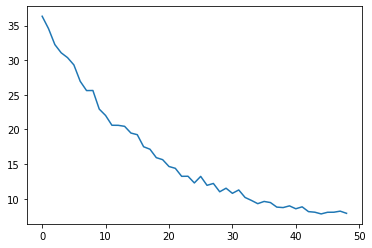

In [51]:
plt.plot(hist_losses[1:]);

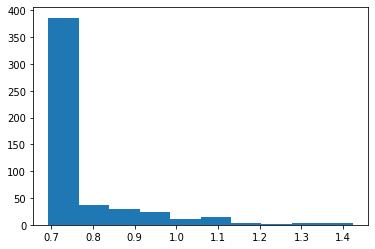

In [52]:
plt.hist(all_pred[-1][:, 1]);

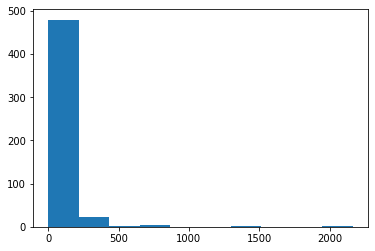

In [53]:
plt.hist(all_pred[-1][:, 0]);

In [55]:
dif_times = np.linspace(0, 300, 30, dtype=np.int)

all_surv_time = pd.DataFrame()
for t in dif_times:
    surv_prob = np.exp(-1 * np.power(t / (all_pred[-1][:, 0] + 1e-6), all_pred[-1][:, 1]))
    all_surv_time = pd.concat([all_surv_time, pd.DataFrame(surv_prob).T])

all_surv_time.index = dif_times

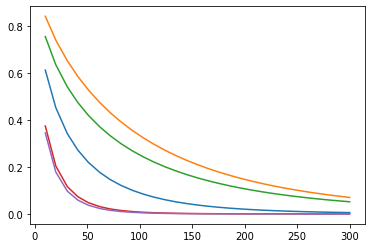

In [63]:
d = all_surv_time.sample(5, axis=1).loc[1:]
obs = d.columns
for o in obs:
    plt.plot(d.index, d[o])

In [57]:
ev1 = EvalSurv(surv=all_surv_time, durations=y_batch[:, 0], events=y_batch[:, 2], censor_surv='km')

In [62]:
ev1.concordance_td('antolini')

0.4814725261439884

In [61]:
ev1.concordance_td()

<bound method EvalSurv.brier_score of <pycox.evaluation.eval_surv.EvalSurv object at 0x7f28a8579320>>

In [64]:
import lifelines

In [78]:
lifelines.utils.concordance_index(predicted_scores=all_surv_time.iloc[10, ].values, event_times=y_batch[:, 0], event_observed=y_batch[:, 2])

0.4955743041942643

In [6]:
class Model(object):
    
    def __init__(self):
        
        # features
        self.x_a = tf.placeholder(tf.float32, (None, 9))
        self.x_b = tf.placeholder(tf.float32, (None, 9))
        
        # time to event
        self.t_a = tf.placeholder(tf.float32, [None, 1], name='t_a')
        self.t_b = tf.placeholder(tf.float32, [None, 1], name='t_b')
        
        # event label
        self.y_a = tf.placeholder(tf.float32, [None, 1], name='y_a')
        self.y_b = tf.placeholder(tf.float32, [None, 1], name='y_b')
        
        self.target = tf.placeholder(tf.float32, [None, 1], name='target')
        self.sample_weight = tf.placeholder(tf.float32, [None, 1], name='sample_weight')
             
        with tf.variable_scope("siamese", reuse=tf.AUTO_REUSE) as scope:
            self.o1 = self.siamese_net(self.x_a)
            scope.reuse_variables()
            self.o2 = self.siamese_net(self.x_b)

        self.loss = self.calc_loss()
    
    def siamese_net(self, x):
        
        # main network
        output = tf.layers.dense(inputs=x, units=4, name='dense')
        
        # weibull parameters layer
        init_kernel = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05)
        y_pred = tf.layers.dense(inputs=output, units=2, bias_initializer=init_kernel, kernel_initializer=init_kernel, name='weibull_parameters')
        alpha = y_pred[:, 0]
        beta = y_pred[:, 1]
        alpha = tf.clip_by_value(alpha, 0, 12, name='alpha_clipping')
        alpha = tf.exp(alpha, name='alpha_act')
        beta = tf.clip_by_value(beta, 0, 2, name='beta_clipping')
        beta = tf.nn.softplus(beta, name='beta_act')
        beta = tf.reshape(beta, (tf.shape(beta)[0], 1), name='beta_reshaped')
        alpha = tf.reshape(alpha, (tf.shape(alpha)[0], 1), name='alpha_reshaped')
        output = tf.concat((alpha, beta), axis=1, name='wp_concat')
        return output

    
    def calc_loss(self):
        
        mean_ll, mean_lh_a, mean_lh_b, mean_sq_alpha = self.binary_survival_loss(self.t_a, self.t_b, self.y_a, self.y_b, self.o1, self.o2, self.target, self.sample_weight)
        return mean_lh_b + mean_lh_a + 1e-3 * mean_sq_alpha + mean_ll


#         return -1 * tf.reduce_mean(lh_a + lh_b, name='mean_loss') + mean_sq_alpha
    
    def calc_survival_value(self, alphas, betas, t): 
        s = tf.exp(-1 * tf.pow(tf.divide(t, alphas + 1e-6), betas))
        return s                                             

    def calc_likelyhood(self, alphas, betas, t, y):
        ev = tf.multiply(y, tf.add(tf.multiply(betas, tf.log(tf.divide(t, alphas + 1e-6))), tf.log(betas)))
        lh = tf.subtract(ev, tf.pow(tf.divide(t, alphas + 1e-6), betas))              
        return lh
    
    def binary_survival_loss(self, t_a, t_b, y_a, y_b, output_a, output_b, target, sample_weight):
        
        sh = tf.shape(t_a)
        alphas = tf.reshape(output_a[:, 0], sh, name='alpha_reshaped_loss')
        betas = tf.reshape(output_a[:, 1], sh, name='beta_reshaped_loss')
        s_a = self.calc_survival_value(t=t_a, alphas=alphas, betas=betas)
        lh_a = self.calc_likelyhood(t=t_a, y=y_a, alphas=alphas, betas=betas)
        mean_lh_a =  -1 * tf.reduce_mean(lh_a)
        all_alphas = alphas
        
        alphas = tf.reshape(output_b[:, 0], sh)
        betas = tf.reshape(output_b[:, 1], sh)        
        s_b = self.calc_survival_value(t=t_b, alphas=alphas, betas=betas)
        lh_b = self.calc_likelyhood(t=t_b, y=y_b, alphas=alphas, betas=betas)
        mean_lh_b =  -1 * tf.reduce_mean(lh_b)
        all_alphas = tf.add(all_alphas, alphas)

        # weighted binary cross entropy
        sigm = tf.nn.sigmoid(s_a - s_b)
        sigm = tf.clip_by_value(sigm, 1e-6, 1 - 1e-6)
        label_pos = tf.multiply(target, tf.log(sigm + 1e-6))
        label_neg = tf.multiply(1 - target, tf.multiply(tf.log(1 + 1e-6 - sigm), sample_weight))
        label_neg = tf.multiply(1 - target, tf.log(1 + 1e-6 - sigm))
        ll = tf.add(label_pos, label_neg)
        mean_ll = -1 * tf.reduce_mean(ll)
        
        # alpha reg
        mean_sq_alpha = tf.reduce_mean(all_alphas)
        
        return mean_ll, mean_lh_a, mean_lh_b, mean_sq_alpha


model = Model()
# optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.99)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = optimizer.minimize(model.loss)
saver = tf.train.Saver()


n_time_bins = 10

# validation data
dg = DataGenerator(x=x_val, y=y_val, t=t_val, batch_size=30228, n_time_bins=n_time_bins)
[x_batch_left_val, x_batch_right_val], y_batch_val, sample_weight_val, target_val = next(dg.get_batch())

batch_size = 1024
dg = DataGenerator(x=x_train, y=y_train, t=t_train, batch_size=batch_size, n_time_bins=n_time_bins)
n_batches = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1]) // batch_size
n_epochs = 50

loss_summary = tf.summary.scalar(name='train_loss', tensor=model.loss) 
val_loss_summary = tf.summary.scalar(name='val_loss', tensor=model.loss)
hist_losses = []
all_pred = []
# Launch the graph
with tf.device('/GPU:0'):
    with tf.Session() as sess:
        init = tf.initialize_all_variables()
        sess.run(init)
        writer = tf.summary.FileWriter('../logs/graphs', sess.graph)
        for i in tqdm(range(n_epochs)):
            gen = dg.get_batch()
            for j in range(n_batches):
                [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                feed_dict = {
                    model.x_a: x_batch_left, 
                    model.x_b: x_batch_right, 
                    model.t_a: y_batch[:, 0].reshape((batch_size, 1)),
                    model.t_b: y_batch[:, 1].reshape((batch_size, 1)),
                    model.y_a: y_batch[:, 2].reshape((batch_size, 1)),
                    model.y_b: y_batch[:, 3].reshape((batch_size, 1)),
                    model.target: target.reshape((batch_size, 1)),
                    model.sample_weight: sample_weight
                }
                _, l = sess.run([train, model.loss], feed_dict=feed_dict)
                
            loss_train = sess.run(loss_summary, feed_dict=feed_dict)
            loss_val = sess.run(val_loss_summary, feed_dict={
                    model.x_a: x_batch_left_val, 
                    model.x_b: x_batch_right_val, 
                    model.t_a: y_batch_val[:, 0].reshape((30228, 1)),
                    model.t_b: y_batch_val[:, 1].reshape((30228, 1)),
                    model.y_a: y_batch_val[:, 2].reshape((30228, 1)),
                    model.y_b: y_batch_val[:, 3].reshape((30228, 1)),
                    model.target: target_val.reshape((30228, 1)),
                    model.sample_weight: sample_weight_val
                })
            writer.add_summary(loss_train, i)
            writer.add_summary(loss_val, i)
            pred = sess.run(model.o1, feed_dict={model.x_a: x_val})
            print(np.mean(pred, axis=0))
            all_pred.append(pred)
            hist_losses.append(l)
            
            saver.save(sess, '../data/my_test_model')


Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.global_variables_initializer` instead.


[132.97273      0.69314605]
[134.43175      0.69314605]
[136.63107      0.69314605]
[137.19327      0.69314605]
[137.57896      0.69314605]
[137.51727      0.69314605]
[137.2914       0.69314605]
[136.65031      0.69314605]
[136.63446      0.69314605]
[136.17172      0.69314605]
[135.86212      0.69314605]
[136.02673      0.69314605]
[135.83699      0.69314605]
[135.79181      0.69314605]
[135.89465      0.69314605]
[135.74014      0.69314605]
[135.92061      0.69314605]
[135.9562       0.69314605]
[135.8465       0.69314605]
[136.00357      0.69314605]
[135.77052      0.69314605]
[135.92442      0.69314605]
[135.67014      0.69314605]
[135.62613      0.69314605]
[136.10237      0.69314605]
[135.90393      0.69314605]
[135.84882      0.69314605]
[135.89622      0.69314605]
[135.6127       0.69314605]
[136.17502      0.69314605]
[135.5987       0.69314605]
[135.80254      0.69314605]
[136.06027      0.69314605]
[135.90211      0.69314605]
[135.90608      0.69314605]
[136.04726      0.69

In [7]:
all_pred[0].shape

(305, 2)

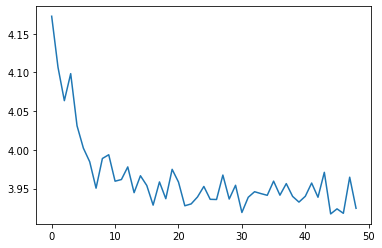

In [8]:
plt.plot(hist_losses[1:]);

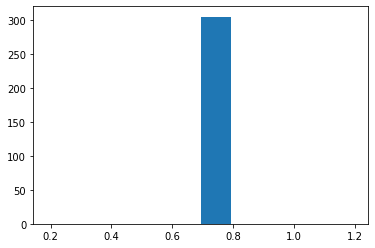

In [9]:
plt.hist(all_pred[-1][:, 1]);

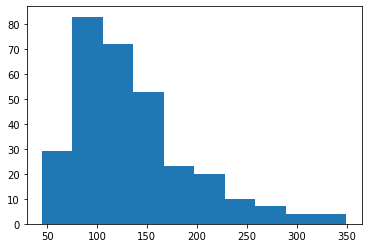

In [10]:
plt.hist(all_pred[-1][:, 0]);

In [11]:
dif_times = np.linspace(0, 300, 30, dtype=np.int)

all_surv_time = pd.DataFrame()
for t in dif_times:
    surv_prob = np.exp(-1 * np.power(t / (all_pred[-1][:, 0] + 1e-6), all_pred[-1][:, 1]))
    all_surv_time = pd.concat([all_surv_time, pd.DataFrame(surv_prob).T])

all_surv_time.index = dif_times

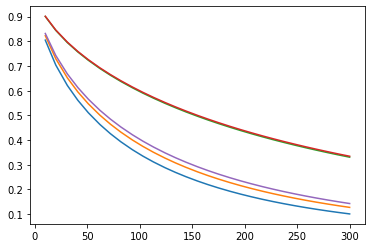

In [27]:
d = all_surv_time.sample(5, axis=1).loc[1:]
obs = d.columns
for o in obs:
    plt.plot(d.index, d[o])

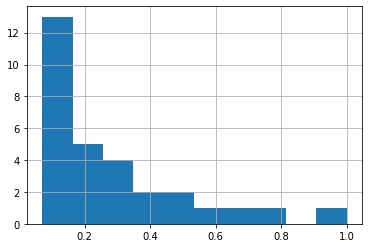

In [26]:
all_surv_time[100].hist();

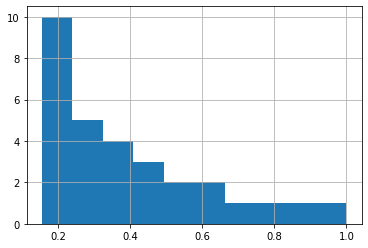

In [28]:
all_surv_time[200].hist();

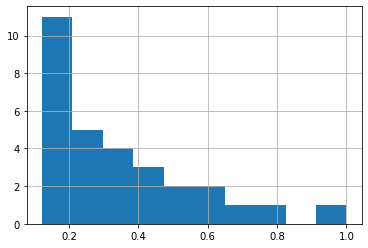

In [30]:
all_surv_time[300].hist();

In [14]:
ev1 = EvalSurv(surv=all_surv_time, durations=t_val, events=y_val, censor_surv='km')

In [15]:
ev1.concordance_td('antolini')

0.60888550729432

In [18]:
lifelines.utils.concordance_index(predicted_scores=all_surv_time.iloc[10, ].values, event_times=t_val, event_observed=y_val)

0.619901419167025

Удвоим вес ранжирующей компоненты

In [7]:
class Model(object):
    
    def __init__(self):
        
        # features
        self.x_a = tf.placeholder(tf.float32, (None, 9))
        self.x_b = tf.placeholder(tf.float32, (None, 9))
        
        # time to event
        self.t_a = tf.placeholder(tf.float32, [None, 1], name='t_a')
        self.t_b = tf.placeholder(tf.float32, [None, 1], name='t_b')
        
        # event label
        self.y_a = tf.placeholder(tf.float32, [None, 1], name='y_a')
        self.y_b = tf.placeholder(tf.float32, [None, 1], name='y_b')
        
        self.target = tf.placeholder(tf.float32, [None, 1], name='target')
        self.sample_weight = tf.placeholder(tf.float32, [None, 1], name='sample_weight')
             
        with tf.variable_scope("siamese", reuse=tf.AUTO_REUSE) as scope:
            self.o1 = self.siamese_net(self.x_a)
            scope.reuse_variables()
            self.o2 = self.siamese_net(self.x_b)

        self.loss = self.calc_loss()
    
    def siamese_net(self, x):
        
        # main network
        init_kernel = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05)
        output = tf.layers.dense(inputs=x, units=4, name='dense',kernel_initializer=init_kernel,
                                bias_initializer=init_kernel)
        
        # weibull parameters layer
        init_kernel = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05)
        y_pred = tf.layers.dense(inputs=output, units=2, bias_initializer=init_kernel,
                                 kernel_initializer=init_kernel, name='weibull_parameters')
        alpha = y_pred[:, 0]
        beta = y_pred[:, 1]
        alpha = tf.clip_by_value(alpha, 0, 12, name='alpha_clipping')
        alpha = tf.exp(alpha, name='alpha_act')
        beta = tf.clip_by_value(beta, 0, 2, name='beta_clipping')
        beta = tf.nn.softplus(beta, name='beta_act')
        beta = tf.reshape(beta, (tf.shape(beta)[0], 1), name='beta_reshaped')
        alpha = tf.reshape(alpha, (tf.shape(alpha)[0], 1), name='alpha_reshaped')
        output = tf.concat((alpha, beta), axis=1, name='wp_concat')
        return output

    
    def calc_loss(self):
        
        mean_ll, mean_lh_a, mean_lh_b, mean_sq_alpha = self.binary_survival_loss(self.t_a, self.t_b, self.y_a, self.y_b, self.o1, self.o2, self.target, self.sample_weight)
        return mean_lh_b + mean_lh_a + 1e-1 * mean_sq_alpha + 4 * mean_ll

#         return -1 * tf.reduce_mean(lh_a + lh_b, name='mean_loss') + mean_sq_alpha
    
    def calc_survival_value(self, alphas, betas, t): 
        s = tf.exp(-1 * tf.pow(tf.divide(t, alphas + 1e-6), betas))
        return s                                             

    def calc_likelyhood(self, alphas, betas, t, y):
        ev = tf.multiply(y, tf.add(tf.multiply(betas, tf.log(tf.divide(t, alphas + 1e-6))), tf.log(betas)))
        lh = tf.subtract(ev, tf.pow(tf.divide(t, alphas + 1e-6), betas))              
        return lh
    
    def binary_survival_loss(self, t_a, t_b, y_a, y_b, output_a, output_b, target, sample_weight):
        
        sh = tf.shape(t_a)
        alphas = tf.reshape(output_a[:, 0], sh, name='alpha_reshaped_loss')
        betas = tf.reshape(output_a[:, 1], sh, name='beta_reshaped_loss')
        s_a = self.calc_survival_value(t=t_a, alphas=alphas, betas=betas)
        lh_a = self.calc_likelyhood(t=t_a, y=y_a, alphas=alphas, betas=betas)
        mean_lh_a =  -1 * tf.reduce_mean(lh_a)
        all_alphas = alphas
        
        alphas = tf.reshape(output_b[:, 0], sh)
        betas = tf.reshape(output_b[:, 1], sh)        
        s_b = self.calc_survival_value(t=t_b, alphas=alphas, betas=betas)
        lh_b = self.calc_likelyhood(t=t_b, y=y_b, alphas=alphas, betas=betas)
        mean_lh_b =  -1 * tf.reduce_mean(lh_b)
        all_alphas = tf.add(all_alphas, alphas)

        # weighted binary cross entropy
        sigm = tf.nn.sigmoid(s_a - s_b)
        sigm = tf.clip_by_value(sigm, 1e-6, 1 - 1e-6)
        label_pos = tf.multiply(target, tf.log(sigm + 1e-6))
        label_neg = tf.multiply(1 - target, tf.multiply(tf.log(1 + 1e-6 - sigm), sample_weight))
        label_neg = tf.multiply(1 - target, tf.log(1 + 1e-6 - sigm))
        ll = tf.add(label_pos, label_neg)
        mean_ll = -1 * tf.reduce_mean(ll)
        
        # alpha reg
        mean_sq_alpha = tf.reduce_mean(all_alphas)
        
        return mean_ll, mean_lh_a, mean_lh_b, mean_sq_alpha


model = Model()
# optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.99)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = optimizer.minimize(model.loss)
saver = tf.train.Saver()


n_time_bins = 10

# validation data
dg = DataGenerator(x=x_val, y=y_val, t=t_val, batch_size=30228, n_time_bins=n_time_bins)
[x_batch_left_val, x_batch_right_val], y_batch_val, sample_weight_val, target_val = next(dg.get_batch())

batch_size = 4112
dg = DataGenerator(x=x_train, y=y_train, t=t_train, batch_size=batch_size, n_time_bins=n_time_bins)
n_batches = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1]) // batch_size
n_epochs = 50

loss_summary = tf.summary.scalar(name='train_loss', tensor=model.loss) 
val_loss_summary = tf.summary.scalar(name='val_loss', tensor=model.loss)
hist_losses = []
all_pred = []
# Launch the graph
with tf.device('/GPU:0'):
    with tf.Session() as sess:
        init = tf.initialize_all_variables()
        sess.run(init)
        writer = tf.summary.FileWriter('../logs/graphs', sess.graph)
        for i in tqdm(range(n_epochs)):
            gen = dg.get_batch()
            for j in range(n_batches):
                [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                feed_dict = {
                    model.x_a: x_batch_left, 
                    model.x_b: x_batch_right, 
                    model.t_a: y_batch[:, 0].reshape((batch_size, 1)),
                    model.t_b: y_batch[:, 1].reshape((batch_size, 1)),
                    model.y_a: y_batch[:, 2].reshape((batch_size, 1)),
                    model.y_b: y_batch[:, 3].reshape((batch_size, 1)),
                    model.target: target.reshape((batch_size, 1)),
                    model.sample_weight: sample_weight
                }
                _, l = sess.run([train, model.loss], feed_dict=feed_dict)
                
            loss_train = sess.run(loss_summary, feed_dict=feed_dict)
            loss_val = sess.run(val_loss_summary, feed_dict={
                    model.x_a: x_batch_left_val, 
                    model.x_b: x_batch_right_val, 
                    model.t_a: y_batch_val[:, 0].reshape((30228, 1)),
                    model.t_b: y_batch_val[:, 1].reshape((30228, 1)),
                    model.y_a: y_batch_val[:, 2].reshape((30228, 1)),
                    model.y_b: y_batch_val[:, 3].reshape((30228, 1)),
                    model.target: target_val.reshape((30228, 1)),
                    model.sample_weight: sample_weight_val
                })
            writer.add_summary(loss_train, i)
            writer.add_summary(loss_val, i)
            pred = sess.run(model.o1, feed_dict={model.x_a: x_val})
            print(np.mean(pred, axis=0))
            all_pred.append(pred)
            hist_losses.append(l)
            
            saver.save(sess, '../data/my_test_model_new')


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.global_variables_initializer` instead.


[10.009656    0.69314605]
[16.722876    0.69314605]
[17.175955    0.69314605]
[17.259703    0.69314605]
[17.302645    0.69314605]
[17.340607    0.69314605]
[17.364315    0.69314605]
[17.378035    0.69314605]
[17.38773     0.69314605]
[17.40781     0.69314605]
[17.414448    0.69314605]
[17.41166     0.69314605]
[17.423603    0.69314605]
[17.427446    0.69314605]
[17.426426    0.69314605]
[17.444418    0.69314605]
[17.445543    0.69314605]
[17.443693    0.69314605]
[17.437506    0.69314605]
[17.45209     0.69314605]
[17.444696    0.69314605]
[17.456997    0.69314605]
[17.454647    0.69314605]
[17.444904    0.69314605]
[17.452364    0.69314605]
[17.465845    0.69314605]
[17.463799    0.69314605]
[17.467476    0.69314605]
[17.457924    0.69314605]
[17.46745     0.69314605]
[17.466772    0.69314605]
[17.468283    0.69314605]
[17.478428    0.69314605]
[17.472769    0.69314605]
[17.473568    0.69314605]
[17.461126    0.69314605]
[17.474068    0.69314605]
[17.473938    0.69314605]
[17.470863  

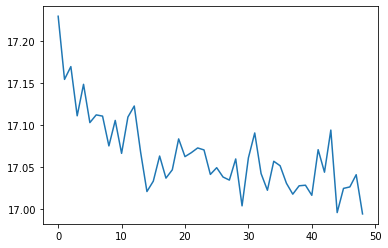

In [8]:
plt.plot(hist_losses[1:]);

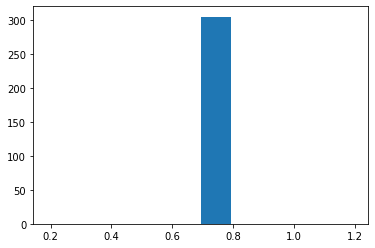

In [9]:
plt.hist(all_pred[-1][:, 1]);

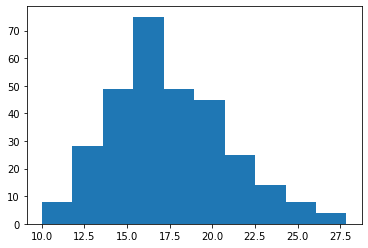

In [10]:
plt.hist(all_pred[-1][:, 0]);

In [11]:
dif_times = np.linspace(0, 300, 30, dtype=np.int)

all_surv_time = pd.DataFrame()
for t in dif_times:
    surv_prob = np.exp(-1 * np.power(t / (all_pred[-1][:, 0] + 1e-6), all_pred[-1][:, 1]))
    all_surv_time = pd.concat([all_surv_time, pd.DataFrame(surv_prob).T])

all_surv_time.index = dif_times

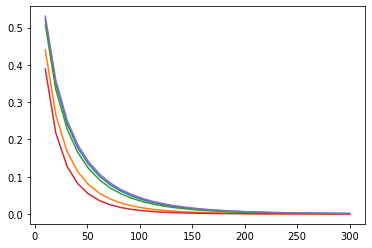

In [13]:
d = all_surv_time.sample(5, axis=1).loc[1:]
obs = d.columns
for o in obs:
    plt.plot(d.index, d[o])

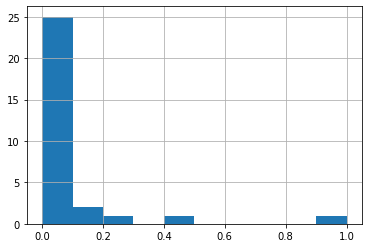

In [14]:
all_surv_time[100].hist();

In [15]:
ev1 = EvalSurv(surv=all_surv_time, durations=t_val, events=y_val, censor_surv='km')

In [16]:
ev1.concordance_td('antolini')

0.6036918191140958

In [17]:
lifelines.utils.concordance_index(predicted_scores=all_surv_time.iloc[10, ].values, event_times=t_val, event_observed=y_val)

0.6160971252770518

Compare with baseline model - same general population alpha-beta

In [54]:
# Paramaeters for output activation layer initialization.
# Start at naive geometric (beta=1) MLE:
tte_mean_train = np.nanmean(t_train)
init_alpha = -1.0 / np.log(1.0 - 1.0 / (tte_mean_train + 1.0) )
mean_u = np.nanmean(y_train)
init_alpha = init_alpha / mean_u
print('init_alpha: ', init_alpha, 'mean uncensored: ', mean_u)

init_alpha:  205.33489420694383 mean uncensored:  0.6042692939244664


In [67]:
baseline_surv_time = pd.DataFrame()

for t in dif_times:
    bas_s = K.eval(calc_survival_value(y_true=np.array([t]), y_pred=np.array([[init_alpha, 1]])))
    baseline_surv_time = pd.concat([baseline_surv_time, pd.DataFrame(np.repeat(bas_s[0], t_test.shape[0])).T])

baseline_surv_time.index = dif_times

In [69]:
ev = EvalSurv(surv=baseline_surv_time, durations=t_test, events=y_test, censor_surv='km')

In [70]:
ev.concordance_td('antolini')

0.0

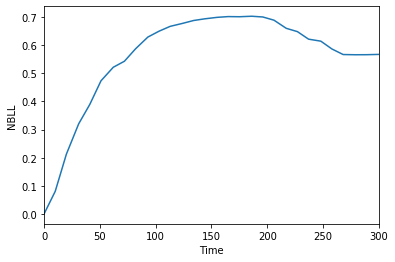

In [83]:
ev.nbll(dif_times).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

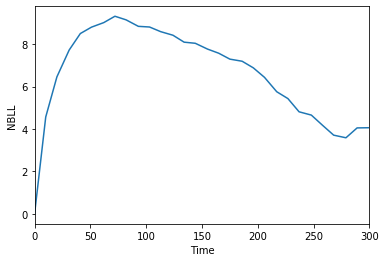

In [84]:
ev1.nbll(dif_times).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

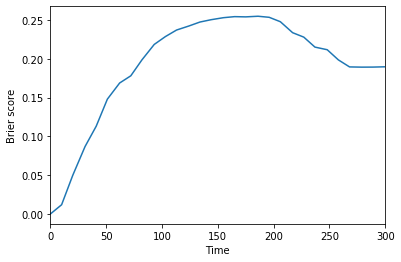

In [85]:
ev.brier_score(dif_times).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

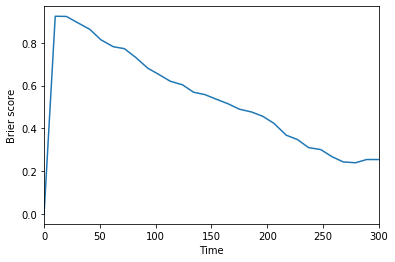

In [86]:
ev1.brier_score(dif_times).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')